In [1]:
import spacy
import numpy as np
import pandas as pd
import re
import jsonlines
from utils.prepare_rules import create_rules 
from utils.prepare_data import create_prepare_file
from utils.expand_model import expand_model
from tqdm import tqdm
import os.path
from spacy.language import Language
from spacy import displacy
import matplotlib.pyplot as plt

In [43]:
DATA='data/pledges - pledges.csv'
BRANDS='data/brands.jsonl'
RULES='data/rules.jsonl'
DATA_PREPARE='data/pledges_prepare.csv'

BRAND_PATH = 'data/brands/'
RULES_PATH = 'data/rules/'

#### Загружаем данные для парсинга и данные по брендам

In [44]:
data = pd.read_csv(DATA, delimiter='|')

In [45]:
brands = list(jsonlines.open(BRANDS))
list_brands = [x['id'] for x in brands]

### Генерируем правила для моделей и марок и сохраняем их в файлы

In [46]:
rules = create_rules(brands)

# save in file
with jsonlines.open(RULES, mode='w') as writer:
    writer.write_all(rules)
    
for brand in list_brands:
    rules_model = create_rules(brands)
    try:
        models = jsonlines.open(BRAND_PATH + brand +'.jsonl')
        rules_model = create_rules(models, label='MODEL', prefix=brand+'_')
        with jsonlines.open(RULES_PATH + brand + '_rules.jsonl', mode='w') as writer:
            writer.write_all(rules_model)
    except:
        pass
#         print('Для бренда '+ brand+ ' не найден файл с моделями ' + BRAND_PATH + brand +'.jsonl')

### Попытаемся отбить пробелы
Возможно это не слишком хорошая идея...

In [47]:
list_models = []
for brand in list_brands:
    try:
        reader = jsonlines.open('data/brands/'+ brand +'.jsonl')
        list_models = list_models + list(reader)
    except:
        pass

In [48]:
str_with_space = create_prepare_file(data=data['vehicleproperty_description_short'].values, brands=brands+list_models)

data['with_space'] = str_with_space
data.to_csv(DATA_PREPARE, index=False)

In [49]:
data = pd.read_csv(DATA_PREPARE, delimiter=',')

### NER

In [50]:
rules = list(jsonlines.open(RULES))
for brand in list_brands:
    if os.path.exists(RULES_PATH + brand + '_rules.jsonl'):
            file = jsonlines.open(RULES_PATH + brand + '_rules.jsonl')
            rules = rules + (list(file))

In [51]:
colors = {"BRAND": "#aa9cfc", "MODEL": "#fc9ce7"}
options = {"ents": ["BRAND", "MODEL"], "colors": colors}

nlp = spacy.load("ru_core_news_sm",exclude=['tok2vec', 'morphologizer', 'parser', 'senter', 'attribute_ruler', 'lemmatizer'])

config = { "overwrite_ents": True }
ruler = nlp.add_pipe("entity_ruler", before="ner", config=config) #.from_disk(RULES_PATH +"all_rules.jsonl", )
ruler.add_patterns(rules)

nlp.add_pipe("expand_model", after="ner")

ents_info = []
html=[]
for article in tqdm(data['with_space']):
    article = str(article)
    doc = nlp(article)
    ents_info.append(doc.user_data)
    html.append(doc if len(doc.ents) == 0 else displacy.render(doc, style="ent", jupyter=False, options=options))
    


100%|█| 10000/10000 [02:25<00:00, 68.


In [52]:
ents_info_df = pd.DataFrame.from_records(ents_info)
data.index.name = 'order'
data = data.join(ents_info_df,on='order')
data = data.assign(HTML = html)

In [53]:
doc = nlp('Прицеп самосвал НЕФАЗ BRAND -8560-05')
for token in doc:
    print(token.text)
doc.ents

Прицеп
самосвал
НЕФАЗ
BRAND
-8560
-
05


(НЕФАЗ, -8560)

In [54]:
brand = 'belaz'.lower()
data.index.name= 'id'

df = data[data['first_brand']==brand][['HTML', 'brands', 'models', 'have_fit_model', 'count_brands','count_models']]
df = df[df['have_fit_model'] == False]
print(df.shape[0])
df = df[0:400]

91


In [55]:
def left_align(s):
    direction = 'left'
    return 'text-align: %s' % direction

df.style.applymap(left_align, subset=pd.IndexSlice[:, ['HTML']])

,HTML,brands,models,have_fit_model,count_brands,count_models
id,,,,,,
550,ГРУЗОВОЙ-САМОСВАЛ БЕЛАЗ BRAND 7555В,belaz,,False,1,0
551,ГРУЗОВОЙ-САМОСВАЛ БЕЛАЗ BRAND 7555В,belaz,,False,1,0
4030,Грузовой самосвал БелАз BRAND 75302VIN 0000328,belaz,,False,1,0
4031,Грузовой самосвал БелАз BRAND 75307VIN 0000327,belaz,,False,1,0
4033,Грузовой самосвал БелАз BRAND 75311,belaz,,False,1,0
4035,Грузовой самосвал БелАз BRAND 75306,belaz,,False,1,0
4036,Грузовой самосвал БелАз BRAND 75306,belaz,,False,1,0
4042,Грузовой самосвал БелАз BRAND 75311,belaz,,False,1,0
4043,Грузовой самосвал БелАз BRAND 75311,belaz,,False,1,0


In [56]:
# data[data['count_models']!=0][data['have_fit_model'] == False].shape[0]
data[data['count_models']==0].shape[0]

3936

/var/folders/2t/mb7xtxlx289fhmxl983vql2c0000gp/T/ipykernel_84456/3268720163.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['count_models']!=0][data['have_fit_model'] == False].shape[0],


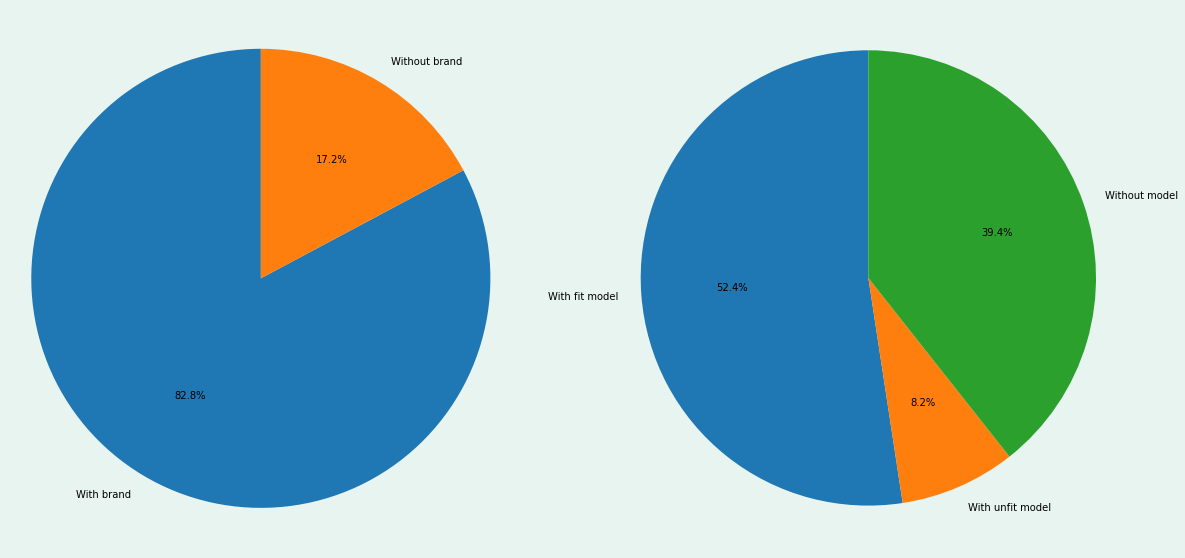

In [57]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='#e8f4f0')

labels = 'With brand', 'Without brand'
sizes = [data.count()['first_brand'], data.shape[0] - data.count()['first_brand']]
ax = axes[0]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

labels = 'With fit model', 'With unfit model', 'Without model'
sizes = [data[
    data['have_fit_model']].shape[0], 
         data[data['count_models']!=0][data['have_fit_model'] == False].shape[0], 
         data[data['count_models']==0].shape[0]]
ax = axes[1]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [62]:
df1 = pd.DataFrame(data['first_brand'].value_counts())
df1.index.name = 'brand'

df2 = data
cols = ["count_models","have_fit_model"]
df2[cols] = data[cols].replace(['0', 0, False], np.nan)

df2 = data.groupby(['first_brand']).count()
df2.index.name = 'brand'

df = df1.join(df2,on='brand')

df = df[['count_brands', 'count_models','have_fit_model']][0:40]


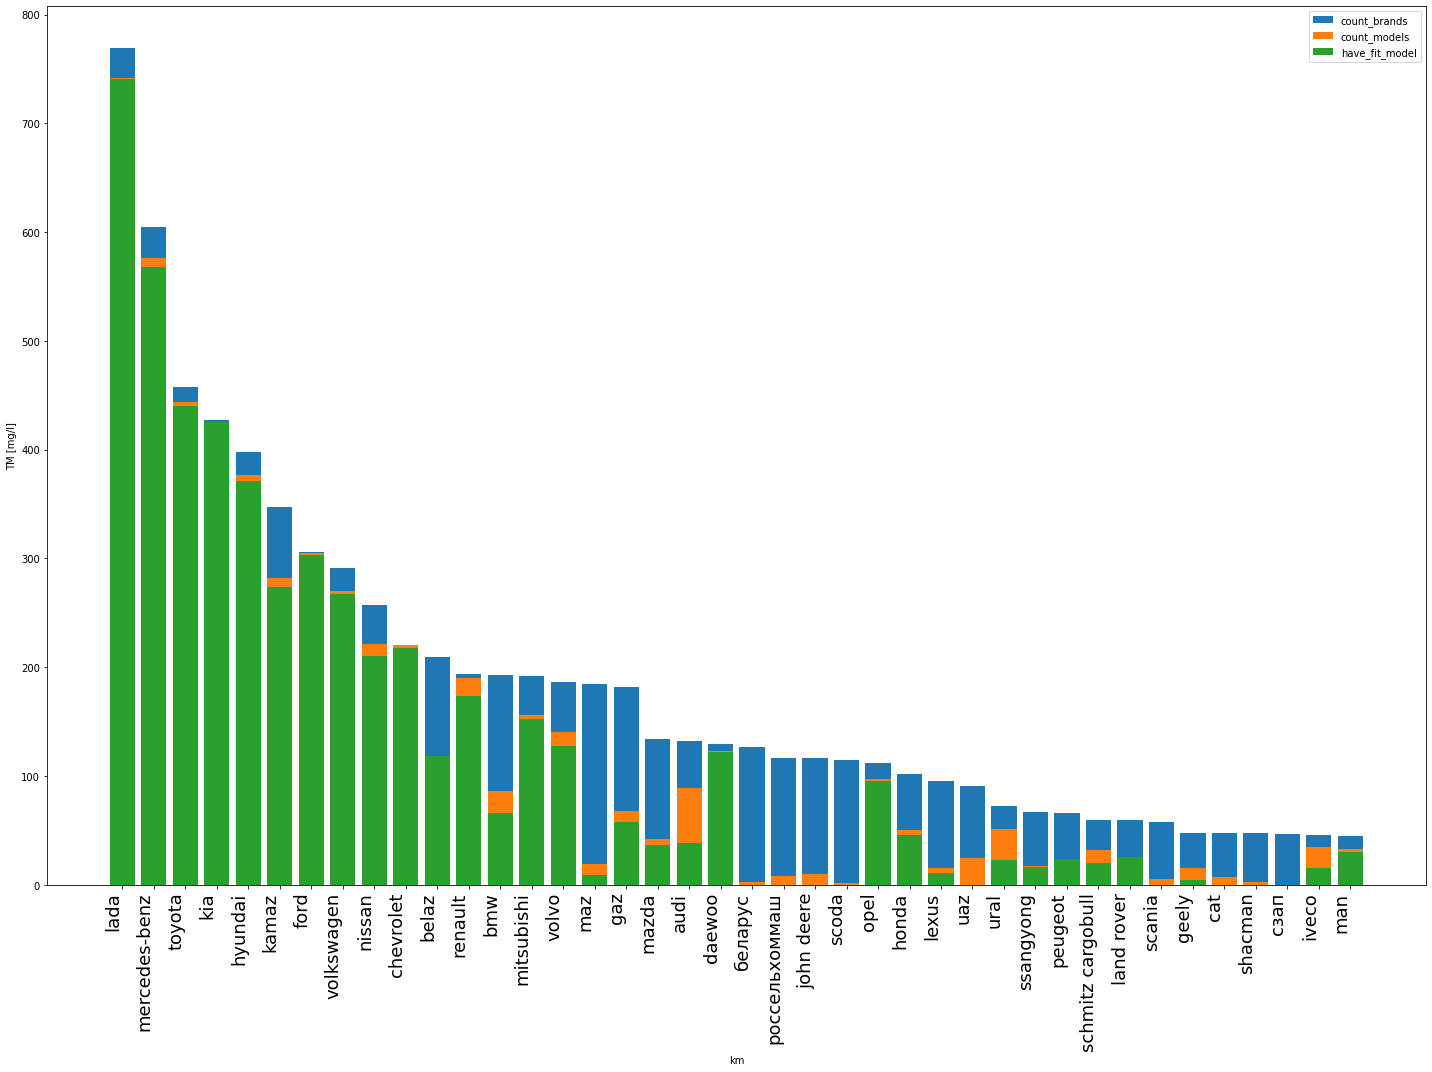

In [63]:
width = 15
bottom = 0

for i in df.columns:
    plt.bar(df.index, df[i])#, width=width) #, bottom=bottom)
    bottom += df[i]

plt.rcParams["figure.figsize"] = (20,15)
plt.xticks(fontsize=18,rotation=90, ha='right')
plt.ylabel('TM [mg/l]')
plt.xlabel('km')
plt.legend(df.columns)
plt.tight_layout()

In [132]:
re.sub(r'^\-?(8560)-?(3)', r' \1 \2 ', "-8560.в")

In [154]:
re.match('^-?8560-?', '-8560') 

<re.Match object; span=(0, 5), match='-8560'>